In [154]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

In [134]:
datos = pd.read_csv("DS_Banca.csv")

datos_y = datos["isFraud"]
print(datos_y.head())

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64


In [ ]:

print(datos.head())

   step      type    amount  isFraud
0     1   PAYMENT   9839.64        0
1     1   PAYMENT   1864.28        0
2     1  TRANSFER    181.00        1
3     1  CASH_OUT    181.00        1
4     1   PAYMENT  11668.14        0


In [135]:
fraud_rates=datos.groupby("type")["isFraud"].mean()
print(fraud_rates)

type
CASH_IN     0.000000
CASH_OUT    0.001840
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.007688
Name: isFraud, dtype: float64


In [137]:
datos['step'] = datos['step'].astype('int32')
datos['isFraud'] = datos['isFraud'].astype('int8')
print(datos.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


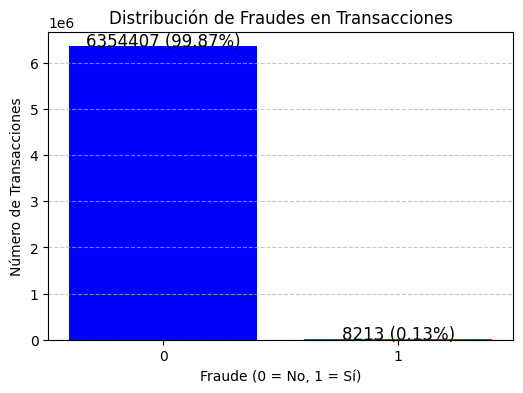

In [138]:
conteo = datos["isFraud"].value_counts()
porcentaje = datos["isFraud"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
plt.bar(conteo.index.astype(str), conteo, color=['blue', 'red'])

for i, (num, perc) in enumerate(zip(conteo, porcentaje)):
    plt.text(i, num + 500, f"{num} ({perc:.2f}%)", ha='center', fontsize=12)

plt.xlabel("Fraude (0 = No, 1 = Sí)")
plt.ylabel("Número de Transacciones")
plt.title("Distribución de Fraudes en Transacciones")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [139]:
datos_x = datos.drop(columns=["isFlaggedFraud"])

In [140]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
x_undersampled, y_undersampled = rus.fit_resample(datos_x, datos_y)

# Verify new class distribution
print("Fraud Cases Before:\n", datos_y.value_counts())
print("Fraud Cases After Undersampling:\n", pd.Series(y_undersampled).value_counts())

Fraud Cases Before:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud Cases After Undersampling:
 isFraud
0    82130
1     8213
Name: count, dtype: int64


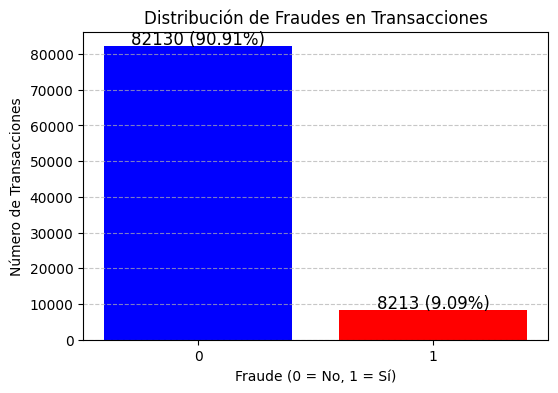

In [141]:
conteo = y_undersampled.value_counts()
porcentaje = y_undersampled.value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
plt.bar(conteo.index.astype(str), conteo, color=['blue', 'red'])

for i, (num, perc) in enumerate(zip(conteo, porcentaje)):
    plt.text(i, num + 500, f"{num} ({perc:.2f}%)", ha='center', fontsize=12)

plt.xlabel("Fraude (0 = No, 1 = Sí)")
plt.ylabel("Número de Transacciones")
plt.title("Distribución de Fraudes en Transacciones")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

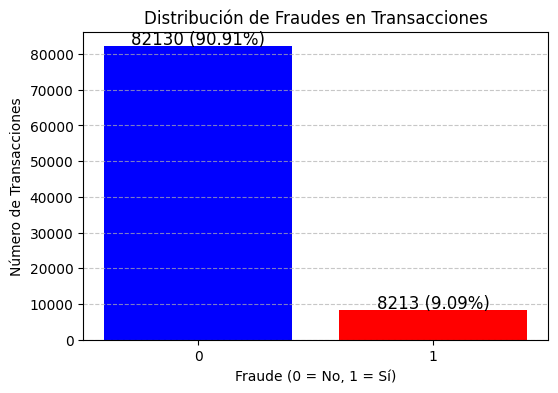

In [142]:
conteo = x_undersampled["isFraud"].value_counts()
porcentaje = x_undersampled["isFraud"].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
plt.bar(conteo.index.astype(str), conteo, color=['blue', 'red'])

for i, (num, perc) in enumerate(zip(conteo, porcentaje)):
    plt.text(i, num + 500, f"{num} ({perc:.2f}%)", ha='center', fontsize=12)

plt.xlabel("Fraude (0 = No, 1 = Sí)")
plt.ylabel("Número de Transacciones")
plt.title("Distribución de Fraudes en Transacciones")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [143]:
x_undersampled['is_transfer'] = (x_undersampled['type'] == 'TRANSFER').astype(int)
x_undersampled['is_cashout'] = (x_undersampled['type'] == 'CASH_OUT').astype(int)
print(x_undersampled.head())

# 1. Number of transactions per origin and destination
x_undersampled['orig_tx_count'] = x_undersampled.groupby('nameOrig')['step'].transform('count')
x_undersampled['dest_tx_count'] = x_undersampled.groupby('nameDest')['step'].transform('count')

# 2. Standard deviation of transaction amounts
x_undersampled['orig_tx_std'] = x_undersampled.groupby('nameOrig')['amount'].transform('std').fillna(0)
x_undersampled['dest_tx_std'] = x_undersampled.groupby('nameDest')['amount'].transform('std').fillna(0)

# 3. Transaction type flags
x_undersampled['is_transfer'] = (x_undersampled['type'] == 'TRANSFER').astype(int)
x_undersampled['is_cashout'] = (x_undersampled['type'] == 'CASH_OUT').astype(int)

# 4. Extract hour of the day from 'step'
x_undersampled['hour_of_day'] = x_undersampled['step'] % 24

# 5. Binary flag for merchant transactions
x_undersampled['is_merchant'] = x_undersampled['nameDest'].str.startswith('M').astype(int)

         step      type     amount     nameOrig  oldbalanceOrg  \
1777056   162  CASH_OUT  183806.32   C691771226       19391.00   
1350600   137   PAYMENT     521.37   C203378011           0.00   
1991933   179   PAYMENT    3478.18  C1698571270       19853.00   
5092368   355   PAYMENT    1716.05   C913764937        5769.17   
5066515   354   CASH_IN  253129.93  C2017736577     1328499.49   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1777056            0.00  C1416312719       382572.19       566378.51        0   
1350600            0.00    M42773300            0.00            0.00        0   
1991933        16374.82   M643984524            0.00            0.00        0   
5092368         4053.13  M1387429131            0.00            0.00        0   
5066515      1581629.42   C407484102      2713220.48      2460090.55        0   

         is_transfer  is_cashout  
1777056            0           1  
1350600            0           0  
1991933    

In [144]:
x_undersampled = x_undersampled.drop(columns=["isFraud", 'nameOrig', 'nameDest'])
print(x_undersampled.head())

         step      type     amount  oldbalanceOrg  newbalanceOrig  \
1777056   162  CASH_OUT  183806.32       19391.00            0.00   
1350600   137   PAYMENT     521.37           0.00            0.00   
1991933   179   PAYMENT    3478.18       19853.00        16374.82   
5092368   355   PAYMENT    1716.05        5769.17         4053.13   
5066515   354   CASH_IN  253129.93     1328499.49      1581629.42   

         oldbalanceDest  newbalanceDest  is_transfer  is_cashout  \
1777056       382572.19       566378.51            0           1   
1350600            0.00            0.00            0           0   
1991933            0.00            0.00            0           0   
5092368            0.00            0.00            0           0   
5066515      2713220.48      2460090.55            0           0   

         orig_tx_count  dest_tx_count  orig_tx_std  dest_tx_std  hour_of_day  \
1777056              1              1          0.0          0.0           18   
1350600         

In [145]:
encoder = LabelEncoder()
x_undersampled['type'] = encoder.fit_transform(x_undersampled['type'])
print(x_undersampled.head())

         step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1777056   162     1  183806.32       19391.00            0.00       382572.19   
1350600   137     3     521.37           0.00            0.00            0.00   
1991933   179     3    3478.18       19853.00        16374.82            0.00   
5092368   355     3    1716.05        5769.17         4053.13            0.00   
5066515   354     0  253129.93     1328499.49      1581629.42      2713220.48   

         newbalanceDest  is_transfer  is_cashout  orig_tx_count  \
1777056       566378.51            0           1              1   
1350600            0.00            0           0              1   
1991933            0.00            0           0              1   
5092368            0.00            0           0              1   
5066515      2460090.55            0           0              1   

         dest_tx_count  orig_tx_std  dest_tx_std  hour_of_day  is_merchant  
1777056              1          0

In [146]:
datos_x

x_train, x_test, y_train, y_test = train_test_split(x_undersampled, y_undersampled, test_size=0.3, random_state=2, stratify=y_undersampled)

print("X Train: {}, X Test: {}, Y Train: {}, Y Test: {}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

X Train: (63240, 15), X Test: (27103, 15), Y Train: (63240,), Y Test: (27103,)


In [147]:
print(y_test.value_counts())

n_entradas1 = x_train.shape[1]
print(n_entradas1)

isFraud
0    24639
1     2464
Name: count, dtype: int64
15


In [148]:
# 📌 Convertir DataFrame a NumPy antes de crear tensores
t_x_train = torch.from_numpy(x_train.to_numpy()).float().to("cpu")
t_x_test = torch.from_numpy(x_test.to_numpy()).float().to("cpu")
t_y_train = torch.from_numpy(y_train.to_numpy()).float().to("cpu")
t_y_test = torch.from_numpy(y_test.to_numpy()).float().to("cpu")

# 📌 Asegurar que las dimensiones sean correctas
t_y_train = t_y_train[:, None]
t_y_test = t_y_test[:, None]

# 📌 Crear dataset de prueba
test = TensorDataset(t_x_test, t_y_test)

# 📌 Verificar si funciona
print(test[0])
print(t_x_train)


(tensor([2.0000e+01, 1.0000e+00, 1.8790e+05, 3.1825e+04, 0.0000e+00, 2.8342e+04,
        2.1624e+05, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+01, 0.0000e+00]), tensor([0.]))
tensor([[2.2700e+02, 3.0000e+00, 6.3239e+04,  ..., 0.0000e+00, 1.1000e+01,
         1.0000e+00],
        [1.6000e+01, 3.0000e+00, 1.0778e+03,  ..., 0.0000e+00, 1.6000e+01,
         1.0000e+00],
        [4.3100e+02, 3.0000e+00, 8.3425e+03,  ..., 0.0000e+00, 2.3000e+01,
         1.0000e+00],
        ...,
        [2.3700e+02, 1.0000e+00, 1.9344e+04,  ..., 0.0000e+00, 2.1000e+01,
         0.0000e+00],
        [2.5400e+02, 1.0000e+00, 4.1636e+05,  ..., 0.0000e+00, 1.4000e+01,
         0.0000e+00],
        [2.0600e+02, 1.0000e+00, 5.5147e+05,  ..., 0.0000e+00, 1.4000e+01,
         0.0000e+00]])


In [149]:
class Red(nn.Module):
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 8)
        self.linear3 = nn.Linear(8, 1)

    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))

        return pred_f

In [150]:
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas1)
print(model.parameters())
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print(model)
historico = pd.DataFrame()

<generator object Module.parameters at 0x0000019FE79AC660>
Red(
  (linear1): Linear(in_features=15, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
)


In [151]:
for epoch in range(1, epochs + 1):
    y_pred = model(t_x_train)
    loss = loss_fn(input= y_pred, target= t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} Loss: {round(loss.item(), 4)}")

    with torch.no_grad():
        y_pred = model(t_x_test)
        y_pred_class = (y_pred >= 0.4).int()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))

    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    },
    index=[0])
    historico = pd.concat(objs= [historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))


Epoch 100 Loss: 0.4326
Accuracy: 90.90875244140625

Epoch 200 Loss: 0.3375
Accuracy: 90.90875244140625

Epoch 300 Loss: 0.3064
Accuracy: 90.90875244140625

Epoch 400 Loss: 0.2951
Accuracy: 90.90875244140625

Epoch 500 Loss: 0.2833
Accuracy: 90.90875244140625

Epoch 600 Loss: 0.2671
Accuracy: 90.90875244140625

Epoch 700 Loss: 0.2455
Accuracy: 90.90875244140625

Epoch 800 Loss: 0.2207
Accuracy: 90.90875244140625

Epoch 900 Loss: 0.1877
Accuracy: 90.90875244140625

Epoch 1000 Loss: 0.1592
Accuracy: 92.96387481689453

Epoch 1100 Loss: 0.1474
Accuracy: 97.08888244628906

Epoch 1200 Loss: 0.1183
Accuracy: 97.72718811035156

Epoch 1300 Loss: 0.1171
Accuracy: 97.29180908203125

Epoch 1400 Loss: 0.1144
Accuracy: 97.08150482177734

Epoch 1500 Loss: 0.1178
Accuracy: 97.14422607421875

Epoch 1600 Loss: 0.0986
Accuracy: 97.78253173828125

Epoch 1700 Loss: 0.1077
Accuracy: 97.43570709228516

Epoch 1800 Loss: 0.0883
Accuracy: 98.06294250488281

Epoch 1900 Loss: 0.0805
Accuracy: 97.80467224121094

E

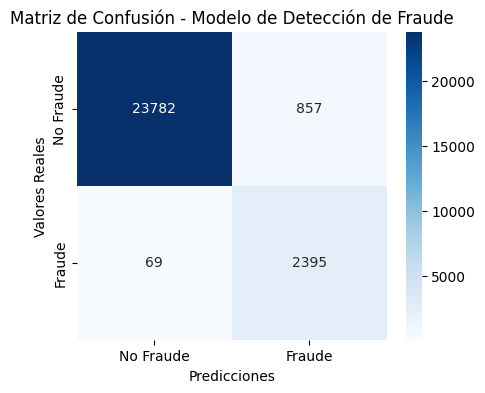

In [161]:
# 📌 Hacer predicciones finales en el conjunto de prueba
with torch.no_grad():
    y_pred = model(t_x_test)
    y_pred_class = (y_pred >= 0.4).int()  # Convertir a numpy

# 📌 Convertir etiquetas reales a numpy
y_test_np = t_y_test.cpu().numpy()

# 📌 Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test_np, y_pred_class)

# 📌 Graficar la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])

# 📌 Etiquetas
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Modelo de Detección de Fraude")

# 📌 Mostrar gráfico
plt.show()

In [162]:
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")


y_test shape: (27103,)
y_pred shape: torch.Size([27103, 1])


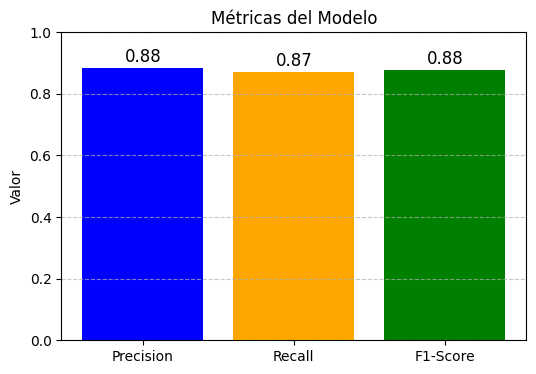

In [166]:
# 📌 Asegurar que `y_pred` contiene solo 0 o 1
y_pred_bin = (y_pred >= 0.5).int()  # 🔹 Convertir a binario con umbral 0.5

# 📌 Convertir `y_test` y `y_pred_bin` a NumPy (si no lo están)
y_test_np = y_test.cpu().numpy().flatten() if isinstance(y_test, torch.Tensor) else y_test
y_pred_np = y_pred_bin.cpu().numpy().flatten() if isinstance(y_pred_bin, torch.Tensor) else y_pred_bin

# 📌 Calcular métricas
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

# 📌 Crear gráfico de barras
metricas = ["Precision", "Recall", "F1-Score"]
valores = [precision, recall, f1]

plt.figure(figsize=(6,4))
plt.bar(metricas, valores, color=['blue', 'orange', 'green'])

# 📌 Mostrar valores en las barras
for i, v in enumerate(valores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

# 📌 Personalizar gráfico
plt.ylim(0, 1)
plt.title("Métricas del Modelo")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 📌 Mostrar gráfico
plt.show()